In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
#import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.preprocessing import StandardScaler
import os
from tensorflow import keras
from keras_tuner import RandomSearch
from tensorflow.keras import layers

In [8]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [9]:
df=pd.read_csv('database.csv')
df.head()

,wavelength,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles,vol_equi_radius_outer,vol_equi_radius_inner,equi_mobility_dia,mie_epsilon,length_scale_factor,...,q_sca,g,c_geo,c_ext,c_abs,c_sca,ssa,mac_total,mac_bc,mac_organics
0,660,1.5,0,15.0,1,15.000000,15.000000,23.829600,2,0.0952,...,0.000389,0.003798,706.858347,0.000083,0.000083,2.750000e-07,0.003318,3.897000,3.897000,0.0
1,660,1.5,0,15.0,2,18.898816,18.898816,33.934547,2,0.0952,...,0.001005,0.008979,1122.067684,0.000173,0.000172,1.130000e-06,0.006529,4.047873,4.047873,0.0
2,660,1.5,0,15.0,4,23.811016,23.811016,48.324498,2,0.0952,...,0.002514,0.022970,1781.171422,0.000362,0.000357,4.480000e-06,0.012376,4.212336,4.212336,0.0
3,660,1.5,0,15.0,6,27.256809,27.256809,59.425643,2,0.0952,...,0.004187,0.037044,2333.994837,0.000550,0.000541,9.770000e-06,0.017756,4.248847,4.248847,0.0
4,660,1.5,0,15.0,8,30.000000,30.000000,68.816510,2,0.0952,...,0.005988,0.051049,2827.433388,0.000745,0.000728,1.690000e-05,0.022730,4.291000,4.291000,0.0


In [10]:
X = df.iloc[:,[0,24,25,26,27]]
Y = df.iloc[:,[1,2,3,4]]
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y.head()

,fractal_dimension,fraction_of_coating,primary_particle_size,number_of_primary_particles
0,1.5,0,15.0,1
1,1.5,0,15.0,2
2,1.5,0,15.0,4
3,1.5,0,15.0,6
4,1.5,0,15.0,8


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, 
        test_size=0.25, 
        random_state=42)
Y_train.shape[1]

4

In [13]:
scaling_x=StandardScaler()
X_train=scaling_x.fit_transform(X_train)
X_test=scaling_x.transform(X_test)


Hyperparameters:
1. No of hideen layers
2. No of neurons in hidden layers
3. Learning rate

In [8]:
def build_model(hp):
    model=keras.Sequential()
    model.add(Input(shape= (X_train.shape[1],)))
    for i in range(hp.Int('num_layers', 3,10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                           min_value=32,
                                           max_value=256,
                                           step=32),
                               activation='relu',
                               kernel_initializer= hp.Choice('kernel_initializer', ['normal','he_normal', 'he_uniform'])))
    model.add(layers.Dense(3, activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(
        hp.Choice('learning_rate', [1e-2, 1e-3])),
        loss='mean_absolute_percentage_error',
        metrics=['mean_absolute_percentage_error'])
        
    return model
        
    
    

In [9]:
tuner=RandomSearch(build_model,
                  objective='val_mean_absolute_percentage_error',
                  max_trials=2,
                  executions_per_trial=1,
                   directory= 'project1',
                   project_name='random_split'
                  )

In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 3, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
kernel_initializer (Choice)
{'default': 'normal', 'conditions': [], 'values': ['normal', 'he_normal', 'he_uniform'], 'ordered': False}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [11]:
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [12]:
tuner.search(X_train, Y_train, epochs=5, batch_size=32, validation_split = 0.2, callbacks=[es])

Trial 2 Complete [00h 00m 07s]
val_mean_absolute_percentage_error: 20.364294052124023

Best val_mean_absolute_percentage_error So Far: 20.364294052124023
Total elapsed time: 00h 00m 15s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [14]:
summary=tuner.results_summary()

Results summary
Results in project1\random_split
Showing 10 best trials
Objective(name='val_mean_absolute_percentage_error', direction='min')
Trial summary
Hyperparameters:
num_layers: 10
units_0: 192
kernel_initializer: he_uniform
units_1: 128
units_2: 128
learning_rate: 0.01
units_3: 192
units_4: 64
units_5: 64
units_6: 192
units_7: 160
units_8: 192
units_9: 96
Score: 20.364294052124023
Trial summary
Hyperparameters:
num_layers: 10
units_0: 128
kernel_initializer: normal
units_1: 64
units_2: 224
learning_rate: 0.001
units_3: 32
units_4: 32
units_5: 32
units_6: 32
units_7: 32
units_8: 32
units_9: 32
Score: 21.62499237060547


NoneType

In [15]:
models = tuner.get_best_models(num_models=2)


In [16]:
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build()
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 192)               1728      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12352     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 192)               1

In [17]:
best_model_2= models[1]

best_model_2.build()
print(best_model_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1152      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 224)               14560     
_________________________________________________________________
dense_3 (Dense)              (None, 32)                7200      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                1

In [14]:
def build_model():
    model=Sequential()
    input_layer= Input(shape= (X_train.shape[1],))
    first_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(input_layer)
    second_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(first_dense)
    third_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(second_dense)
    fourth_dense=Dense(units=256, kernel_initializer='normal', activation= 'relu')(third_dense)
    fifth_dense=Dense(units=224, kernel_initializer='normal', activation= 'relu')(fourth_dense)
    sixth_dense=Dense(units=128, kernel_initializer='normal', activation= 'relu')(fifth_dense)
    seventh_dense=Dense(units=64, kernel_initializer='normal', activation= 'relu')(sixth_dense)
    eighth_dense=Dense(units=32, kernel_initializer='normal', activation= 'relu')(seventh_dense)
    output_dense=Dense(units=4, kernel_initializer='normal', activation= 'relu')(eighth_dense)
    #output_dense[:,0]=tf.keras.activations.sigmoid(output_dense[:,0])
    #output_q_abs=  tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,0:1])
    #output_q_sca= tf.keras.layers.Activation(tf.nn.softplus)(output_dense[:,1:2])
    #output_g= tf.keras.layers.Activation(tf.nn.sigmoid)(output_dense[:,2:3])
    #print(output_dense.shape)
   
    
    #model=tf.keras.Model(inputs=input_layer, outputs= [output_q_abs, output_q_sca, output_g])
    model=tf.keras.Model(inputs=input_layer, outputs= output_dense)
    
    return model
    
    

In [15]:
model= build_model()

#optimizer= tf.keras.optimizers.Adam(lr= 0.001)
# model.compile(optimizer='adam',
#              loss={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              },
#              metrics={
#                  'q_abs': 'mean_absolute_percentage_error',
#                  'q_sca': 'mean_absolute_percentage_error',
#                  'g': 'mean_absolute_percentage_error'
#              })
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense (Dense)                (None, 256)               1536      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               57600     
_________________________________________________________________
dense_4 (Dense)              (None, 224)               57568     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               28800 

In [16]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger


In [17]:
filepath="inverse_random_split_with_min_max_2/best_model.hdf5"

checkpoint = ModelCheckpoint(filepath, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')  

In [21]:
# # patient early stopping
es = EarlyStopping(monitor='val_loss', patience=100, verbose=1)

In [22]:
log_csv=CSVLogger('inverse_random_split_loss_logs.csv', separator=',', append=False)

In [23]:
callback_list=[checkpoint, es, log_csv]

In [24]:
history= model.fit(X_train, Y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callback_list)
#history= NN_model.fit(X_train, Y_train, epochs=7, batch_size=32, validation_split = 0.2)

Epoch 1/500
185/185 [==============================] - 4s 7ms/step - loss: 112.8904 - mean_absolute_percentage_error: 112.8904 - val_loss: 70.1096 - val_mean_absolute_percentage_error: 70.1096

Epoch 00001: val_loss improved from inf to 70.10965, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 2/500
185/185 [==============================] - 1s 6ms/step - loss: 69.6022 - mean_absolute_percentage_error: 69.6022 - val_loss: 69.0559 - val_mean_absolute_percentage_error: 69.0559

Epoch 00002: val_loss improved from 70.10965 to 69.05585, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 3/500
185/185 [==============================] - 1s 6ms/step - loss: 68.9887 - mean_absolute_percentage_error: 68.9887 - val_loss: 68.6733 - val_mean_absolute_percentage_error: 68.6733

Epoch 00003: val_loss improved from 69.05585 to 68.67332, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 4/500
185/185 [============================

185/185 [==============================] - 1s 6ms/step - loss: 27.5343 - mean_absolute_percentage_error: 27.5343 - val_loss: 27.6403 - val_mean_absolute_percentage_error: 27.6403

Epoch 00030: val_loss did not improve from 27.37889
Epoch 31/500
185/185 [==============================] - 1s 6ms/step - loss: 27.8598 - mean_absolute_percentage_error: 27.8598 - val_loss: 28.0588 - val_mean_absolute_percentage_error: 28.0588

Epoch 00031: val_loss did not improve from 27.37889
Epoch 32/500
185/185 [==============================] - 1s 7ms/step - loss: 27.7635 - mean_absolute_percentage_error: 27.7635 - val_loss: 27.2296 - val_mean_absolute_percentage_error: 27.2296

Epoch 00032: val_loss improved from 27.37889 to 27.22963, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 33/500
185/185 [==============================] - 1s 6ms/step - loss: 27.4696 - mean_absolute_percentage_error: 27.4696 - val_loss: 28.0776 - val_mean_absolute_percentage_error: 28.0776

Epoch 00033

185/185 [==============================] - 1s 6ms/step - loss: 24.9530 - mean_absolute_percentage_error: 24.9530 - val_loss: 25.8532 - val_mean_absolute_percentage_error: 25.8532

Epoch 00061: val_loss did not improve from 25.06976
Epoch 62/500
185/185 [==============================] - 1s 6ms/step - loss: 25.0149 - mean_absolute_percentage_error: 25.0149 - val_loss: 24.9631 - val_mean_absolute_percentage_error: 24.9631

Epoch 00062: val_loss improved from 25.06976 to 24.96308, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 63/500
185/185 [==============================] - 1s 6ms/step - loss: 24.9214 - mean_absolute_percentage_error: 24.9214 - val_loss: 25.3802 - val_mean_absolute_percentage_error: 25.3802

Epoch 00063: val_loss did not improve from 24.96308
Epoch 64/500
185/185 [==============================] - 1s 6ms/step - loss: 24.9543 - mean_absolute_percentage_error: 24.9543 - val_loss: 25.6145 - val_mean_absolute_percentage_error: 25.6145

Epoch 00064

185/185 [==============================] - 1s 6ms/step - loss: 24.3128 - mean_absolute_percentage_error: 24.3128 - val_loss: 24.7229 - val_mean_absolute_percentage_error: 24.7229

Epoch 00092: val_loss did not improve from 24.18666
Epoch 93/500
185/185 [==============================] - 1s 6ms/step - loss: 24.5784 - mean_absolute_percentage_error: 24.5784 - val_loss: 25.1039 - val_mean_absolute_percentage_error: 25.1039

Epoch 00093: val_loss did not improve from 24.18666
Epoch 94/500
185/185 [==============================] - 1s 6ms/step - loss: 24.4776 - mean_absolute_percentage_error: 24.4776 - val_loss: 25.7512 - val_mean_absolute_percentage_error: 25.7512

Epoch 00094: val_loss did not improve from 24.18666
Epoch 95/500
185/185 [==============================] - 1s 6ms/step - loss: 24.5023 - mean_absolute_percentage_error: 24.5023 - val_loss: 25.6180 - val_mean_absolute_percentage_error: 25.6180

Epoch 00095: val_loss did not improve from 24.18666
Epoch 96/500
185/185 [===========

185/185 [==============================] - 1s 6ms/step - loss: 24.0923 - mean_absolute_percentage_error: 24.0923 - val_loss: 24.3919 - val_mean_absolute_percentage_error: 24.3919

Epoch 00125: val_loss did not improve from 23.99571
Epoch 126/500
185/185 [==============================] - 1s 6ms/step - loss: 23.9247 - mean_absolute_percentage_error: 23.9247 - val_loss: 24.2993 - val_mean_absolute_percentage_error: 24.2993

Epoch 00126: val_loss did not improve from 23.99571
Epoch 127/500
185/185 [==============================] - 1s 6ms/step - loss: 23.9745 - mean_absolute_percentage_error: 23.9745 - val_loss: 24.5325 - val_mean_absolute_percentage_error: 24.5325

Epoch 00127: val_loss did not improve from 23.99571
Epoch 128/500
185/185 [==============================] - 1s 6ms/step - loss: 24.1356 - mean_absolute_percentage_error: 24.1356 - val_loss: 24.3796 - val_mean_absolute_percentage_error: 24.3796

Epoch 00128: val_loss did not improve from 23.99571
Epoch 129/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 23.5303 - mean_absolute_percentage_error: 23.5303 - val_loss: 24.1796 - val_mean_absolute_percentage_error: 24.1796

Epoch 00157: val_loss did not improve from 23.50185
Epoch 158/500
185/185 [==============================] - 1s 6ms/step - loss: 23.7115 - mean_absolute_percentage_error: 23.7115 - val_loss: 23.7982 - val_mean_absolute_percentage_error: 23.7982

Epoch 00158: val_loss did not improve from 23.50185
Epoch 159/500
185/185 [==============================] - 1s 6ms/step - loss: 23.6021 - mean_absolute_percentage_error: 23.6021 - val_loss: 24.2120 - val_mean_absolute_percentage_error: 24.2120

Epoch 00159: val_loss did not improve from 23.50185
Epoch 160/500
185/185 [==============================] - 1s 6ms/step - loss: 23.6267 - mean_absolute_percentage_error: 23.6267 - val_loss: 23.8580 - val_mean_absolute_percentage_error: 23.8580

Epoch 00160: val_loss did not improve from 23.50185
Epoch 161/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.9321 - mean_absolute_percentage_error: 22.9321 - val_loss: 23.5919 - val_mean_absolute_percentage_error: 23.5919

Epoch 00189: val_loss did not improve from 23.39893
Epoch 190/500
185/185 [==============================] - 1s 6ms/step - loss: 23.0010 - mean_absolute_percentage_error: 23.0010 - val_loss: 23.7274 - val_mean_absolute_percentage_error: 23.7274

Epoch 00190: val_loss did not improve from 23.39893
Epoch 191/500
185/185 [==============================] - 1s 6ms/step - loss: 23.0531 - mean_absolute_percentage_error: 23.0531 - val_loss: 23.7903 - val_mean_absolute_percentage_error: 23.7903

Epoch 00191: val_loss did not improve from 23.39893
Epoch 192/500
185/185 [==============================] - 1s 6ms/step - loss: 23.1012 - mean_absolute_percentage_error: 23.1012 - val_loss: 24.3407 - val_mean_absolute_percentage_error: 24.3407

Epoch 00192: val_loss did not improve from 23.39893
Epoch 193/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 23.0952 - mean_absolute_percentage_error: 23.0952 - val_loss: 23.9783 - val_mean_absolute_percentage_error: 23.9783

Epoch 00221: val_loss did not improve from 23.09941
Epoch 222/500
185/185 [==============================] - 1s 6ms/step - loss: 22.9669 - mean_absolute_percentage_error: 22.9669 - val_loss: 23.6781 - val_mean_absolute_percentage_error: 23.6781

Epoch 00222: val_loss did not improve from 23.09941
Epoch 223/500
185/185 [==============================] - 1s 6ms/step - loss: 22.8183 - mean_absolute_percentage_error: 22.8183 - val_loss: 24.3332 - val_mean_absolute_percentage_error: 24.3332

Epoch 00223: val_loss did not improve from 23.09941
Epoch 224/500
185/185 [==============================] - 1s 6ms/step - loss: 22.9060 - mean_absolute_percentage_error: 22.9060 - val_loss: 23.7170 - val_mean_absolute_percentage_error: 23.7170

Epoch 00224: val_loss did not improve from 23.09941
Epoch 225/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.7854 - mean_absolute_percentage_error: 22.7854 - val_loss: 23.1035 - val_mean_absolute_percentage_error: 23.1035

Epoch 00254: val_loss did not improve from 22.88756
Epoch 255/500
185/185 [==============================] - 1s 6ms/step - loss: 22.6731 - mean_absolute_percentage_error: 22.6731 - val_loss: 23.1116 - val_mean_absolute_percentage_error: 23.1116

Epoch 00255: val_loss did not improve from 22.88756
Epoch 256/500
185/185 [==============================] - 1s 6ms/step - loss: 22.6555 - mean_absolute_percentage_error: 22.6555 - val_loss: 23.2210 - val_mean_absolute_percentage_error: 23.2210

Epoch 00256: val_loss did not improve from 22.88756
Epoch 257/500
185/185 [==============================] - 1s 6ms/step - loss: 22.6426 - mean_absolute_percentage_error: 22.6426 - val_loss: 23.2875 - val_mean_absolute_percentage_error: 23.2875

Epoch 00257: val_loss did not improve from 22.88756
Epoch 258/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.5078 - mean_absolute_percentage_error: 22.5078 - val_loss: 23.4889 - val_mean_absolute_percentage_error: 23.4889

Epoch 00287: val_loss did not improve from 22.81502
Epoch 288/500
185/185 [==============================] - 1s 6ms/step - loss: 22.5605 - mean_absolute_percentage_error: 22.5605 - val_loss: 23.6681 - val_mean_absolute_percentage_error: 23.6681

Epoch 00288: val_loss did not improve from 22.81502
Epoch 289/500
185/185 [==============================] - 1s 6ms/step - loss: 22.4638 - mean_absolute_percentage_error: 22.4638 - val_loss: 23.3472 - val_mean_absolute_percentage_error: 23.3472

Epoch 00289: val_loss did not improve from 22.81502
Epoch 290/500
185/185 [==============================] - 1s 6ms/step - loss: 22.5601 - mean_absolute_percentage_error: 22.5601 - val_loss: 23.5030 - val_mean_absolute_percentage_error: 23.5030

Epoch 00290: val_loss did not improve from 22.81502
Epoch 291/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.3286 - mean_absolute_percentage_error: 22.3286 - val_loss: 23.1367 - val_mean_absolute_percentage_error: 23.1367

Epoch 00320: val_loss did not improve from 22.66854
Epoch 321/500
185/185 [==============================] - 1s 6ms/step - loss: 22.5060 - mean_absolute_percentage_error: 22.5060 - val_loss: 24.1316 - val_mean_absolute_percentage_error: 24.1316

Epoch 00321: val_loss did not improve from 22.66854
Epoch 322/500
185/185 [==============================] - 1s 6ms/step - loss: 6272.2085 - mean_absolute_percentage_error: 6272.2085 - val_loss: 24.4077 - val_mean_absolute_percentage_error: 24.4077

Epoch 00322: val_loss did not improve from 22.66854
Epoch 323/500
185/185 [==============================] - 1s 6ms/step - loss: 23.6604 - mean_absolute_percentage_error: 23.6604 - val_loss: 24.3861 - val_mean_absolute_percentage_error: 24.3861

Epoch 00323: val_loss did not improve from 22.66854
Epoch 324/500
185/185 [===

185/185 [==============================] - 1s 6ms/step - loss: 22.3636 - mean_absolute_percentage_error: 22.3636 - val_loss: 23.2965 - val_mean_absolute_percentage_error: 23.2965

Epoch 00353: val_loss did not improve from 22.66854
Epoch 354/500
185/185 [==============================] - 1s 6ms/step - loss: 22.2976 - mean_absolute_percentage_error: 22.2976 - val_loss: 22.7861 - val_mean_absolute_percentage_error: 22.7861

Epoch 00354: val_loss did not improve from 22.66854
Epoch 355/500
185/185 [==============================] - 1s 6ms/step - loss: 22.2921 - mean_absolute_percentage_error: 22.2921 - val_loss: 23.2024 - val_mean_absolute_percentage_error: 23.2024

Epoch 00355: val_loss did not improve from 22.66854
Epoch 356/500
185/185 [==============================] - 1s 6ms/step - loss: 22.2243 - mean_absolute_percentage_error: 22.2243 - val_loss: 22.9536 - val_mean_absolute_percentage_error: 22.9536

Epoch 00356: val_loss did not improve from 22.66854
Epoch 357/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.2174 - mean_absolute_percentage_error: 22.2174 - val_loss: 22.8682 - val_mean_absolute_percentage_error: 22.8682

Epoch 00386: val_loss did not improve from 22.61180
Epoch 387/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1780 - mean_absolute_percentage_error: 22.1780 - val_loss: 23.0097 - val_mean_absolute_percentage_error: 23.0097

Epoch 00387: val_loss did not improve from 22.61180
Epoch 388/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1964 - mean_absolute_percentage_error: 22.1964 - val_loss: 22.5541 - val_mean_absolute_percentage_error: 22.5541

Epoch 00388: val_loss improved from 22.61180 to 22.55410, saving model to inverse_random_split_with_min_max_2\best_model.hdf5
Epoch 389/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1141 - mean_absolute_percentage_error: 22.1141 - val_loss: 23.4197 - val_mean_absolute_percentage_error: 23.4197

Epoch 00

185/185 [==============================] - 1s 6ms/step - loss: 22.2136 - mean_absolute_percentage_error: 22.2136 - val_loss: 23.1563 - val_mean_absolute_percentage_error: 23.1563

Epoch 00419: val_loss did not improve from 22.55410
Epoch 420/500
185/185 [==============================] - 1s 6ms/step - loss: 22.5373 - mean_absolute_percentage_error: 22.5373 - val_loss: 22.8746 - val_mean_absolute_percentage_error: 22.8746

Epoch 00420: val_loss did not improve from 22.55410
Epoch 421/500
185/185 [==============================] - 1s 6ms/step - loss: 22.3545 - mean_absolute_percentage_error: 22.3545 - val_loss: 23.0655 - val_mean_absolute_percentage_error: 23.0655

Epoch 00421: val_loss did not improve from 22.55410
Epoch 422/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1726 - mean_absolute_percentage_error: 22.1726 - val_loss: 23.6792 - val_mean_absolute_percentage_error: 23.6792

Epoch 00422: val_loss did not improve from 22.55410
Epoch 423/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.4796 - mean_absolute_percentage_error: 22.4796 - val_loss: 22.9855 - val_mean_absolute_percentage_error: 22.9855

Epoch 00452: val_loss did not improve from 22.55410
Epoch 453/500
185/185 [==============================] - 1s 6ms/step - loss: 22.4638 - mean_absolute_percentage_error: 22.4638 - val_loss: 22.9863 - val_mean_absolute_percentage_error: 22.9863

Epoch 00453: val_loss did not improve from 22.55410
Epoch 454/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1018 - mean_absolute_percentage_error: 22.1018 - val_loss: 22.7404 - val_mean_absolute_percentage_error: 22.7404

Epoch 00454: val_loss did not improve from 22.55410
Epoch 455/500
185/185 [==============================] - 1s 6ms/step - loss: 22.2203 - mean_absolute_percentage_error: 22.2203 - val_loss: 23.0229 - val_mean_absolute_percentage_error: 23.0229

Epoch 00455: val_loss did not improve from 22.55410
Epoch 456/500
185/185 [=======

185/185 [==============================] - 1s 6ms/step - loss: 22.1396 - mean_absolute_percentage_error: 22.1396 - val_loss: 22.7806 - val_mean_absolute_percentage_error: 22.7806

Epoch 00485: val_loss did not improve from 22.42612
Epoch 486/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1467 - mean_absolute_percentage_error: 22.1467 - val_loss: 22.7715 - val_mean_absolute_percentage_error: 22.7715

Epoch 00486: val_loss did not improve from 22.42612
Epoch 487/500
185/185 [==============================] - 1s 6ms/step - loss: 22.1561 - mean_absolute_percentage_error: 22.1561 - val_loss: 22.7099 - val_mean_absolute_percentage_error: 22.7099

Epoch 00487: val_loss did not improve from 22.42612
Epoch 488/500
185/185 [==============================] - 1s 7ms/step - loss: 22.1242 - mean_absolute_percentage_error: 22.1242 - val_loss: 22.9150 - val_mean_absolute_percentage_error: 22.9150

Epoch 00488: val_loss did not improve from 22.42612
Epoch 489/500
185/185 [=======

In [25]:
# latest=tf.train.latest_checkpoint(checkpoint_dir)
weights_file = 'inverse_random_split_with_min_max_2/best_model.hdf5' # choose the best checkpoint 
model.load_weights(weights_file) # load it
model.compile(loss='mean_absolute_percentage_error', optimizer='adam', metrics=['mean_absolute_percentage_error'])

In [26]:
#model.save('random_split_model.h5')

Train loss: 21.907, Validation loss: 22.435


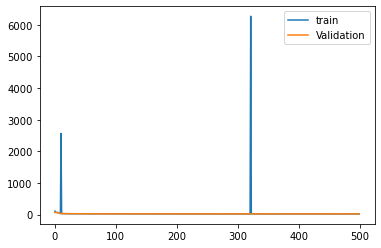

In [27]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=0)
print('Train loss: %.3f, Validation loss: %.3f' % (train_loss, test_loss))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='Validation')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_percentage_error

In [29]:
Y_pred = model.predict(X_test)
#Y_pred[0]= pd.DataFrame(Y_pred[0], columns =['q_abs'])
#Y_pred[1]= pd.DataFrame(Y_pred[1], columns =['q_sca'])
#Y_pred[2]= pd.DataFrame(Y_pred[2], columns =['g'])
#predictions= pd.concat([Y_pred[0], Y_pred[1], Y_pred[2]], axis=1)
#predictions

In [30]:
error= mean_absolute_percentage_error(Y_test, Y_pred, multioutput='raw_values')   
error=error*100
print('Mean absolute percentage error on test set: ', error)

Mean absolute percentage error on test set:  [ 2.91218558 79.89417989  1.86817451  5.06453071]
